# Prof. Pedram Jahangiry

You need to make a copy to your own Google drive if you want to edit the original notebook! Start by opening this notebook on Colab 👇

<a href="https://colab.research.google.com/github/PJalgotrader/Deep_Learning-USU/blob/main/Lectures%20and%20codes/DL%20Spring%202023/Module%205-%20Deep%20Computer%20Vision/CNN_python/Module%205-%20CNN_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> 



![logo](https://upload.wikimedia.org/wikipedia/commons/4/44/Huntsman-Wordmark-with-USU-Blue.gif#center) 


## 🔗 Links

[![linkedin](https://img.shields.io/badge/LinkedIn-0A66C2?style=for-the-badge&logo=linkedin&logoColor=white)](https://www.linkedin.com/in/pedram-jahangiry-cfa-5778015a)

[![Youtube](https://img.shields.io/badge/youtube_channel-1DA1F2?style=for-the-badge&logo=youtube&logoColor=white&color=FF0000)](https://www.youtube.com/channel/UCNDElcuuyX-2pSatVBDpJJQ)

[![Twitter URL](https://img.shields.io/twitter/url/https/twitter.com/PedramJahangiry.svg?style=social&label=Follow%20%40PedramJahangiry)](https://twitter.com/PedramJahangiry)


---


# Module 6- Deep Sequence Modeling (Part 2: NLP)

This module provides a comprehensive overview of fundamental concepts and techniques related to deep sequence modeling. Part one explores deep learning for timeseries data, highlighting the inadequacy of DNN and CNN architectures for this task and introducing the recurrent neural network (RNN) as a solution. Part two delves into deep learning for natural language processing (NLP), illustrating how neural networks can be employed to process human language. The module concludes with a practical exercise in which students apply the concepts they have learned to build a deep sequence model and perform NLP tasks using TensorFlow in Python.

This notebook has been adapted from Deep learning with Python (2nd edition). Francois Chollet
https://github.com/fchollet/deep-learning-with-python-notebooks

# Installation

* If you want to run your code on Google Colab, there is no installation required. (recommended for the course)
* If you want to run your code locally, then you need to install tensorflow https://www.tensorflow.org/install 



In [1]:
import tensorflow 
tensorflow.__version__

'2.12.0'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Preparing text data

We start by TextVectorization: : the process of transforming text into numeric values.


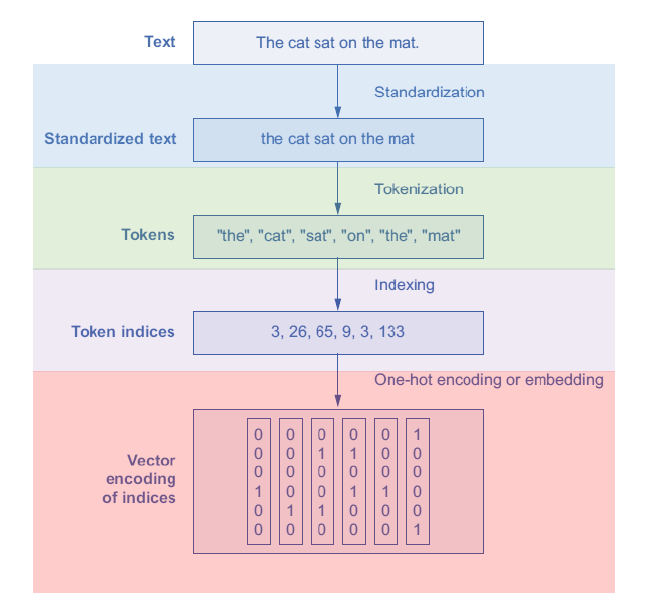

In [135]:
from tensorflow.keras.layers import TextVectorization
text_vectorization = TextVectorization(output_mode='int',) # return sequence of words encoded as integers. 


Remember: 
* To index the vocabulary of a text corpus, we can call the **adapt()** method. 
* To **retrieve** the computed vocabulary we can use **get_vocabulary()** method. 
* index 0 and 1 are reserved for padding and OOV (out of vocabulary), respectively. 
* TextVectorization layer uses "convert to lowercase" and "remove punctuation" for **standardization**, and "split on whitespace" for **tokenization**. 


In [136]:
text_data = ["The Cat Sat on THE mAT!!!"] # this is the entire data set you want to adapt. 
text_vectorization.adapt(text_data)

In [137]:
text_vectorization.get_vocabulary()

['', '[UNK]', 'the', 'sat', 'on', 'mat', 'cat']

In [138]:
text_vectorization(text_data)

<tf.Tensor: shape=(1, 6), dtype=int64, numpy=array([[2, 6, 3, 4, 2, 5]])>

Now let's encode a new test data based on our existing vectorizer. 

In [139]:
# Define some input text

input_text = "Cat on the table?"

In [140]:
# Call the TextVectorization layer on the input text

encoded_input = text_vectorization(input_text)
print(encoded_input)

tf.Tensor([6 4 2 1], shape=(4,), dtype=int64)


Now let's translate this list of integers back into their corresponding words. 

In [141]:
# Get the vocabulary and index-to-word mapping

vocabulary= text_vectorization.get_vocabulary()

In [142]:
index_to_word = dict(enumerate(vocabulary))
index_to_word

{0: '', 1: '[UNK]', 2: 'the', 3: 'sat', 4: 'on', 5: 'mat', 6: 'cat'}

In [143]:
decoded_input = " ".join(index_to_word[int(i)] for i in encoded_input)
print(decoded_input)

cat on the [UNK]


# Importing the IMBD data

Download the dataset from Stanford page of Andrew Maas! this is a balanced dataset with 12.5k positive and 12.5k negative reviews for the train and test set (25k each).

In [58]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  8711k      0  0:00:09  0:00:09 --:--:-- 16.3M


We don't need the unsup subdirectory.

In [59]:
!rm -r aclImdb/train/unsup

We can checkout one of the reviews from the train set! 

In [60]:
!cat aclImdb/train/pos/10001_10.txt

Brilliant over-acting by Lesley Ann Warren. Best dramatic hobo lady I have ever seen, and love scenes in clothes warehouse are second to none. The corn on face is a classic, as good as anything in Blazing Saddles. The take on lawyers is also superb. After being accused of being a turncoat, selling out his boss, and being dishonest the lawyer of Pepto Bolt shrugs indifferently "I'm a lawyer" he says. Three funny words. Jeffrey Tambor, a favorite from the later Larry Sanders show, is fantastic here too as a mad millionaire who wants to crush the ghetto. His character is more malevolent than usual. The hospital scene, and the scene where the homeless invade a demolition site, are all-time classics. Look for the legs scene and the two big diggers fighting (one bleeds). This movie gets better each time I see it (which is quite often).

## preparing train, val and test data folders

In [ ]:
# moving 20% of the train data into a new folder called val. 
import os, pathlib, shutil, random

base_dir = pathlib.Path("aclImdb") # define the directories that will be used to store the data.
val_dir = base_dir / "val"
train_dir = base_dir / "train"
for category in ("neg", "pos"):
    os.makedirs(val_dir / category) # Creates a subdirectory in val_dir with the name of the category (e.g. "val/neg").
    files = os.listdir(train_dir / category) # Lists all the files in the corresponding category directory in train_dir.
    random.Random(1337).shuffle(files) # Shuffles the list of files in a reproducible way using a fixed seed (1337).
    num_val_samples = int(0.2 * len(files)) # Calculates the number of validation samples as 20% of the total number of files in the category.
    val_files = files[-num_val_samples:] # Selects the last num_val_samples files in the shuffled list as the validation files.
    for fname in val_files: # Moves each validation file from train_dir to val_dir for the current category using shutil.move()
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)

We use **text_dataset_from_directory** utility to create batched Dataset of text and lables. This is analogous to what we used in CNN, image_dataset_from_directory. 

In [64]:
from tensorflow import keras
batch_size = 32

train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", batch_size=batch_size
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [72]:
# Displaying the shapes and dtypes of the first batch**

for inputs, targets in train_ds.take(1):
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print("inputs[0]:", inputs[0])
    print("targets[0]:", targets[0])
    

inputs.shape: (32,)
inputs.dtype: <dtype: 'string'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>
inputs[0]: tf.Tensor(b'"THINGS TO COME" Movie Review by kWRice<br /><br />Here is another wonder filled science fiction film from a different time and place. It is a film I\'ve only seen in truncated parts, but Art should be taken as a whole. I experienced this film as it was designed, in a darkened theatre, on a silver screen, with whirling reels of film and an audience to share it with. That audience and myself were effected by this film! One woman who lived through WW II was choked up by the remembered ravages of war and replenished by the positive, albeit corny, ending.<br /><br />The things that caught my attention from the beginning were the initial credits. The first thing we see is "H.G. Wells" in bold angular block copy much like the "Superman" of yore. It is not the film title, but the creator\'s title, and then before any other humans, such as actors or production, are li

# Representing groups of words

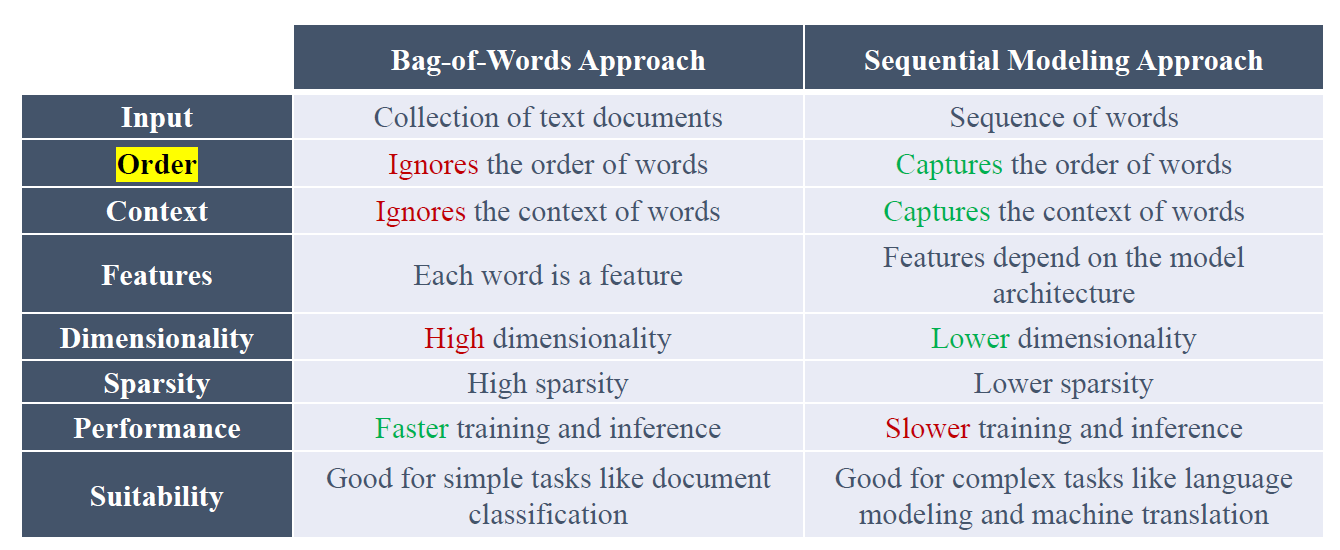


## Bag-of-words



### 1.Single words (Unigrams) with binary encoding (multi-hot)

In [73]:
text_vectorization = TextVectorization(
    max_tokens=20000,
    output_mode="multi_hot",
) # This layer will be used to vectorize the textual data in the datasets.

# prepare the TextVectorization layer for use by fitting it to the training dataset.  
text_only_train_ds = train_ds.map(lambda x,y : x) # discarding the labels y. 
text_vectorization.adapt(text_only_train_ds) #  adapt method analyzes the text data to generate a vocabulary and configure the layer's settings for text processing.

# creating new datasets with the vectorized data
binary_1gram_train_ds = train_ds.map(
    lambda x,y : (text_vectorization(x), y),
    num_parallel_calls=4) #  The num_parallel_calls argument specifies the number of parallel calls to use for the mapping operation, which can speed up processing for large datasets.
binary_1gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_1gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

In [75]:
for inputs, targets in binary_1gram_train_ds.take(1):
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print("inputs[0]:", inputs[0])
    print("targets[0]:", targets[0])
    

inputs.shape: (32, 20000)
inputs.dtype: <dtype: 'float32'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>
inputs[0]: tf.Tensor([1. 1. 1. ... 0. 0. 0.], shape=(20000,), dtype=float32)
targets[0]: tf.Tensor(0, shape=(), dtype=int32)


In [76]:
# Building the model

from tensorflow import keras
from tensorflow.keras import layers

def get_model(max_tokens=20000, hidden_dim=16):
    inputs = keras.Input(shape=(max_tokens,))
    x = layers.Dense(hidden_dim, activation="relu")(inputs)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model

In [77]:
model = get_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense (Dense)               (None, 16)                320016    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320,033
Trainable params: 320,033
Non-trainable params: 0
_________________________________________________________________


In [78]:
# Training the model

callbacks = [
    keras.callbacks.ModelCheckpoint("binary_1gram.keras",
                                    save_best_only=True)
]
model.fit(binary_1gram_train_ds.cache(),
          validation_data=binary_1gram_val_ds.cache(),
          epochs=10,
          callbacks=callbacks)


Epoch 1/10
625/625 [==============================] - 10s 8ms/step - loss: 0.4242 - accuracy: 0.8227 - val_loss: 0.2952 - val_accuracy: 0.8840
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 0.2929 - accuracy: 0.8916 - val_loss: 0.2900 - val_accuracy: 0.8870
Epoch 3/10
625/625 [==============================] - 3s 4ms/step - loss: 0.2556 - accuracy: 0.9093 - val_loss: 0.2887 - val_accuracy: 0.8886
Epoch 4/10
625/625 [==============================] - 2s 4ms/step - loss: 0.2378 - accuracy: 0.9161 - val_loss: 0.3071 - val_accuracy: 0.8890
Epoch 5/10
625/625 [==============================] - 3s 4ms/step - loss: 0.2236 - accuracy: 0.9216 - val_loss: 0.3270 - val_accuracy: 0.8852
Epoch 6/10
625/625 [==============================] - 3s 5ms/step - loss: 0.2177 - accuracy: 0.9259 - val_loss: 0.3336 - val_accuracy: 0.8884
Epoch 7/10
625/625 [==============================] - 2s 4ms/step - loss: 0.2203 - accuracy: 0.9309 - val_loss: 0.3375 - val_accuracy: 0.8856
Epoch

In [79]:
# Testing the model 

model = keras.models.load_model("binary_1gram.keras")
print(f"Test acc: {model.evaluate(binary_1gram_test_ds)[1]:.3f}")

782/782 [==============================] - 4s 5ms/step - loss: 0.3005 - accuracy: 0.8845
Test acc: 0.885


### 2.Two words (Bigrams) with binary encoding (multi-hot)

In [80]:
text_vectorization = TextVectorization(
    ngrams=2,
    max_tokens=20000,
    output_mode="multi_hot",
)

In [82]:
text_vectorization.adapt(text_only_train_ds)
binary_2gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_2gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_2gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

In [83]:
model = get_model()
callbacks = [
    keras.callbacks.ModelCheckpoint("binary_2gram.keras",
                                    save_best_only=True)
]
model.fit(binary_2gram_train_ds.cache(),
          validation_data=binary_2gram_val_ds.cache(),
          epochs=10,
          callbacks=callbacks)

Epoch 1/10
625/625 [==============================] - 7s 11ms/step - loss: 0.3817 - accuracy: 0.8413 - val_loss: 0.2646 - val_accuracy: 0.8978
Epoch 2/10
625/625 [==============================] - 2s 4ms/step - loss: 0.2389 - accuracy: 0.9168 - val_loss: 0.2598 - val_accuracy: 0.9018
Epoch 3/10
625/625 [==============================] - 2s 4ms/step - loss: 0.1975 - accuracy: 0.9337 - val_loss: 0.2744 - val_accuracy: 0.9002
Epoch 4/10
625/625 [==============================] - 2s 4ms/step - loss: 0.1796 - accuracy: 0.9445 - val_loss: 0.2910 - val_accuracy: 0.9000
Epoch 5/10
625/625 [==============================] - 3s 5ms/step - loss: 0.1654 - accuracy: 0.9492 - val_loss: 0.3157 - val_accuracy: 0.8966
Epoch 6/10
625/625 [==============================] - 2s 4ms/step - loss: 0.1624 - accuracy: 0.9531 - val_loss: 0.3165 - val_accuracy: 0.8950
Epoch 7/10
625/625 [==============================] - 2s 4ms/step - loss: 0.1601 - accuracy: 0.9547 - val_loss: 0.3336 - val_accuracy: 0.8952
Epoch

In [ ]:
model = keras.models.load_model("binary_2gram.keras")
print(f"Test acc: {model.evaluate(binary_2gram_test_ds)[1]:.3f}")

782/782 [==============================] - 4s 5ms/step - loss: 0.2655 - accuracy: 0.8978
Test acc: 0.898


### 3.Two words (Bigrams) with TF-IDF encoding

In [85]:
text_vectorization = TextVectorization(
    ngrams=2,
    max_tokens=20000,
    output_mode="tf_idf",
)

In [86]:
text_vectorization.adapt(text_only_train_ds)

tfidf_2gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
tfidf_2gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
tfidf_2gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)


In [87]:
model = get_model()
callbacks = [
    keras.callbacks.ModelCheckpoint("tfidf_2gram.keras",
                                    save_best_only=True)
]
model.fit(tfidf_2gram_train_ds.cache(),
          validation_data=tfidf_2gram_val_ds.cache(),
          epochs=10,
          callbacks=callbacks)


Epoch 1/10
625/625 [==============================] - 7s 10ms/step - loss: 0.4681 - accuracy: 0.7959 - val_loss: 0.3111 - val_accuracy: 0.8822
Epoch 2/10
625/625 [==============================] - 2s 4ms/step - loss: 0.2972 - accuracy: 0.8864 - val_loss: 0.2866 - val_accuracy: 0.8940
Epoch 3/10
625/625 [==============================] - 3s 4ms/step - loss: 0.2615 - accuracy: 0.9018 - val_loss: 0.3011 - val_accuracy: 0.8844
Epoch 4/10
625/625 [==============================] - 3s 5ms/step - loss: 0.2414 - accuracy: 0.9072 - val_loss: 0.3379 - val_accuracy: 0.8656
Epoch 5/10
625/625 [==============================] - 2s 4ms/step - loss: 0.2241 - accuracy: 0.9123 - val_loss: 0.3380 - val_accuracy: 0.8534
Epoch 6/10
625/625 [==============================] - 2s 4ms/step - loss: 0.2211 - accuracy: 0.9129 - val_loss: 0.3362 - val_accuracy: 0.8712
Epoch 7/10
625/625 [==============================] - 2s 4ms/step - loss: 0.2092 - accuracy: 0.9166 - val_loss: 0.3518 - val_accuracy: 0.8760
Epoch

In [88]:
model = keras.models.load_model("tfidf_2gram.keras")
print(f"Test acc: {model.evaluate(tfidf_2gram_test_ds)[1]:.3f}")

782/782 [==============================] - 5s 6ms/step - loss: 0.2899 - accuracy: 0.8883
Test acc: 0.888


## Sequence model approach 


In [113]:
# preparing integer sequence datasets 

from tensorflow.keras import layers

max_length = 600
max_tokens = 20000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

### 1.One-hot encoding approach

In [114]:
import tensorflow as tf
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = tf.one_hot(inputs, depth=max_tokens)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras",
                                    save_best_only=True)
]

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, None)]            0         
                                                                 
 tf.one_hot (TFOpLambda)     (None, None, 20000)       0         
                                                                 
 bidirectional (Bidirectiona  (None, 64)               5128448   
 l)                                                              
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,128,513
Trainable params: 5,128,513
Non-trainable params: 0
_________________________________________________

In [115]:
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)

Epoch 1/10
625/625 [==============================] - 166s 258ms/step - loss: 0.5736 - accuracy: 0.6987 - val_loss: 0.3930 - val_accuracy: 0.8540
Epoch 2/10
625/625 [==============================] - 162s 259ms/step - loss: 0.3661 - accuracy: 0.8604 - val_loss: 0.3422 - val_accuracy: 0.8646
Epoch 3/10
625/625 [==============================] - 159s 255ms/step - loss: 0.2989 - accuracy: 0.8908 - val_loss: 0.3794 - val_accuracy: 0.8370
Epoch 4/10
625/625 [==============================] - 161s 258ms/step - loss: 0.2506 - accuracy: 0.9116 - val_loss: 0.3084 - val_accuracy: 0.8728
Epoch 5/10
625/625 [==============================] - 162s 259ms/step - loss: 0.2182 - accuracy: 0.9254 - val_loss: 0.2999 - val_accuracy: 0.8836
Epoch 6/10
625/625 [==============================] - 162s 260ms/step - loss: 0.1964 - accuracy: 0.9334 - val_loss: 0.2929 - val_accuracy: 0.8820
Epoch 7/10
625/625 [==============================] - 160s 256ms/step - loss: 0.1735 - accuracy: 0.9437 - val_loss: 0.3183 -

In [116]:
model = keras.models.load_model("one_hot_bidir_lstm.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

782/782 [==============================] - 96s 122ms/step - loss: 0.3195 - accuracy: 0.8680
Test acc: 0.868


### 2.Word embedding approach

#### 2.1.Word embedding wihtout masking

In [117]:
embedding_layer = layers.Embedding(input_dim=max_tokens, output_dim=256)

In [118]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_lstm.keras",
                                    save_best_only=True)
]

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 256)         5120000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               73984     
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 5,194,049
Trainable params: 5,194,049
Non-trainable params: 0
_________________________________________________

In [119]:
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)


Epoch 1/10
625/625 [==============================] - 91s 140ms/step - loss: 0.5086 - accuracy: 0.7548 - val_loss: 0.3895 - val_accuracy: 0.8364
Epoch 2/10
625/625 [==============================] - 47s 76ms/step - loss: 0.3459 - accuracy: 0.8680 - val_loss: 0.3352 - val_accuracy: 0.8720
Epoch 3/10
625/625 [==============================] - 38s 61ms/step - loss: 0.2735 - accuracy: 0.9014 - val_loss: 0.3296 - val_accuracy: 0.8790
Epoch 4/10
625/625 [==============================] - 31s 50ms/step - loss: 0.2346 - accuracy: 0.9186 - val_loss: 0.3347 - val_accuracy: 0.8624
Epoch 5/10
625/625 [==============================] - 30s 47ms/step - loss: 0.2050 - accuracy: 0.9288 - val_loss: 0.3974 - val_accuracy: 0.8398
Epoch 6/10
625/625 [==============================] - 27s 43ms/step - loss: 0.1724 - accuracy: 0.9441 - val_loss: 0.5191 - val_accuracy: 0.8652
Epoch 7/10
625/625 [==============================] - 30s 48ms/step - loss: 0.1553 - accuracy: 0.9513 - val_loss: 0.3565 - val_accuracy

In [120]:
model = keras.models.load_model("embeddings_bidir_gru.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

782/782 [==============================] - 14s 17ms/step - loss: 0.3592 - accuracy: 0.8685
Test acc: 0.869


#### 2.2.Word embedding with masking

In [121]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(
    input_dim=max_tokens, output_dim=256, mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_lstm_with_masking.keras",
                                    save_best_only=True)
]


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_2 (Embedding)     (None, None, 256)         5120000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               73984     
 nal)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 5,194,049
Trainable params: 5,194,049
Non-trainable params: 0
_________________________________________________

In [122]:
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)


Epoch 1/10
625/625 [==============================] - 85s 124ms/step - loss: 0.4412 - accuracy: 0.7892 - val_loss: 0.3157 - val_accuracy: 0.8692
Epoch 2/10
625/625 [==============================] - 47s 76ms/step - loss: 0.2759 - accuracy: 0.8913 - val_loss: 0.2929 - val_accuracy: 0.8768
Epoch 3/10
625/625 [==============================] - 38s 61ms/step - loss: 0.2073 - accuracy: 0.9226 - val_loss: 0.3901 - val_accuracy: 0.8488
Epoch 4/10
625/625 [==============================] - 35s 56ms/step - loss: 0.1603 - accuracy: 0.9409 - val_loss: 0.3130 - val_accuracy: 0.8830
Epoch 5/10
625/625 [==============================] - 32s 52ms/step - loss: 0.1256 - accuracy: 0.9564 - val_loss: 0.4246 - val_accuracy: 0.8690
Epoch 6/10
625/625 [==============================] - 34s 55ms/step - loss: 0.0936 - accuracy: 0.9682 - val_loss: 0.3700 - val_accuracy: 0.8742
Epoch 7/10
625/625 [==============================] - 33s 53ms/step - loss: 0.0721 - accuracy: 0.9770 - val_loss: 0.4232 - val_accuracy

In [123]:
model = keras.models.load_model("embeddings_bidir_gru_with_masking.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

782/782 [==============================] - 17s 19ms/step - loss: 0.2993 - accuracy: 0.8759
Test acc: 0.876


#### 2.3.Pre-trained word embedding 

Let's use GloVe scheme for word embedding: https://nlp.stanford.edu/projects/glove/

In [126]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

--2023-03-30 20:27:30--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2023-03-30 20:27:30--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-03-30 20:27:31--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [127]:
# Parsing the GloVe word-embeddings file
import numpy as np

# GloVe word-embeddings file, which contains pre-trained word vectors that can be used to initialize a neural network's embedding layer
path_to_glove_file = "glove.6B.100d.txt" 

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1) #  The maxsplit=1 argument ensures that the split is only performed once, so that the coefficients string can contain spaces.
        coefs = np.fromstring(coefs, "f", sep=" ") # This line converts the string of coefficients to a NumPy array of float32 values. values should be separated by spaces.
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")
# the GloVe file contains pre-trained word vectors for 400,000 unique words. 


Found 400000 word vectors.


By loading pre-trained word vectors, you can avoid the need to train your own word embeddings from scratch, which can be a time-consuming process that requires large amounts of text data. Pre-trained word vectors can also be useful in cases where you have limited training data and need to rely on pre-existing knowledge about the relationships between words to achieve good performance on your task.

The following block of code populates the **embedding_matrix** with the pre-trained GloVe word embeddings. 

For each token in the vocabulary, the corresponding embedding vector is retrieved from the embeddings_index dictionary that was created earlier. If the vector is not None, it is assigned to the corresponding row of the embedding_matrix. If the vocabulary size is larger than max_tokens, only the first max_tokens tokens are used and the rest are ignored.

Overall, this code prepares a matrix of pre-trained word embeddings that can be used to initialize the embedding layer in a neural network for a natural language processing task. The embedding layer can then be trained along with the rest of the model using the training data, or it can be kept fixed and used to extract features from new text data.

In [128]:
embedding_dim = 100

vocabulary = text_vectorization.get_vocabulary()
word_index = dict(zip(vocabulary, range(len(vocabulary)))) # maps each token in the vocabulary to an integer index.

embedding_matrix = np.zeros((max_tokens, embedding_dim))
for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [129]:
embedding_layer = layers.Embedding(
    max_tokens, # The maximum vocabulary size, which was previously defined as 20,000
    embedding_dim, # The dimensionality of the word embeddings, which was previously defined as 100.
    embeddings_initializer=keras.initializers.Constant(embedding_matrix), # used to initialize the weights with the pre-trained GloVe word embeddings that were loaded earlier.
    trainable=False, # specifies whether the weights of the embedding layer should be trainable during training of the model
    mask_zero=True, # specifies whether the embedding layer should treat zeros as a special "padding" value that should be masked out during training.
)

In [130]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("glove_embeddings_sequence_model.keras",
                                    save_best_only=True)
]


Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_3 (Embedding)     (None, None, 100)         2000000   
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               34048     
 nal)                                                            
                                                                 
 dropout_7 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 2,034,113
Trainable params: 34,113
Non-trainable params: 2,000,000
____________________________________________

In [131]:
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)


625/625 [==============================] - 43s 54ms/step - loss: 0.5747 - accuracy: 0.6934 - val_loss: 0.4747 - val_accuracy: 0.7724
Epoch 2/10
625/625 [==============================] - 30s 48ms/step - loss: 0.4467 - accuracy: 0.7965 - val_loss: 0.4258 - val_accuracy: 0.8098
Epoch 3/10
625/625 [==============================] - 32s 51ms/step - loss: 0.3980 - accuracy: 0.8268 - val_loss: 0.3858 - val_accuracy: 0.8314
Epoch 4/10
625/625 [==============================] - 30s 48ms/step - loss: 0.3665 - accuracy: 0.8415 - val_loss: 0.3603 - val_accuracy: 0.8452
Epoch 5/10
625/625 [==============================] - 32s 50ms/step - loss: 0.3407 - accuracy: 0.8540 - val_loss: 0.3577 - val_accuracy: 0.8400
Epoch 6/10
625/625 [==============================] - 30s 48ms/step - loss: 0.3176 - accuracy: 0.8670 - val_loss: 0.3614 - val_accuracy: 0.8444
Epoch 7/10
625/625 [==============================] - 32s 51ms/step - loss: 0.3049 - accuracy: 0.8716 - val_loss: 0.3516 - val_accuracy: 0.8458
Epo

In [132]:
model = keras.models.load_model("glove_embeddings_sequence_model.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

782/782 [==============================] - 20s 22ms/step - loss: 0.3042 - accuracy: 0.8709
Test acc: 0.871


# Making predictions on new data!

In [133]:
# laoding your prefered model first. 
model = keras.models.load_model("binary_2gram.keras")

text_vectorization = TextVectorization(
    ngrams=2,
    max_tokens=20000,
    output_mode="multi_hot",
)


# Adapt the TextVectorization layer to the training data
text_vectorization.adapt(text_only_train_ds)


In [134]:
input_text = ["That was an excellent movie, I loved it.", "This was the worst movie ever. I hated it!!"] # list of your new reviews
vectorized_text = text_vectorization(input_text)
output = model.predict(vectorized_text)
print(output)

1/1 [==============================] - 0s 137ms/step
[[0.8897062 ]
 [0.08977917]]


Done!